In [1]:
import os
from os.path import join, dirname
import pandas as pd
import sys


SOURCE_CODE_PARENT = join(dirname(os.getcwd()), "src")

DATA_PARENT = join(dirname(os.getcwd()), "data")

sys.path.append(SOURCE_CODE_PARENT)

import math
import pandas as pd

from alerts import summarize

from alerts.preprocess import data2timeseries

In [2]:
def load_data(path_name: str) -> pd.DataFrame:
    data = pd.read_csv(f"{path_name}.csv", index_col=0)
    return data


def get_alerts(results):
    alerts_days = [
        day_results["date"]
        for day_results in results
        if not math.isnan(day_results["volume"])
    ]
    return alerts_days


def get_docs_per_day(data, alerts_day):
    texts_per_day = {
        day: summarize.select_texts_per_day(data, day) for day in alerts_day
    }
    return texts_per_day


def df_to_df_time_series(data: pd.DataFrame) -> pd.DataFrame:
    if "date" not in data.columns:
        data["date"] = data["created_at"].apply(lambda x: x[:10])
    df_ts = data2timeseries(data)
    return df_ts

In [3]:
name_data = "Sintomas_intestinales_uruguay"  #'congo_virus_data'#'immigration_data'#'diarrhea_vomit_data'#'20230921_Morocco_Health'#'20230922_Derechos LGTBIQ+'#'20230915_Morocco_Earthquake'#'Sintomas_intestinales_uruguay' '20230915_Morocco_Earthquake' 'Morocco_Earthquake''Libya_flood' 'Diarrhea+Vomit test' 'immigration-ie' 'Congo virus - Pakistan - Data (1)'
csv_file = join(DATA_PARENT, name_data)
data = load_data(csv_file)
data.head(3)

,text,created_at,lang,source,name,screen_name,bio,us_created_at,followers_count,friends_count,statuses_count,favourites_count,country,country_code,locality,region,sub_region,coordinates
id,,,,,,,,,,,,,,,,,,
1613402886142308353,"Me acabé de despertar con anciedad, lo único q...",2023-01-12T05:09:58+00:00,es,twitter,L✨,@letiigonzalez17,22 años ❄️ ♍️ virgo,2015-07-17T22:46:12+00:00,177,151,14140,8818,Uruguay,UY,NaN,NaN,NaN,"-33.0, -56.0"
1613399780641611776,Puedo decir que ya recuerdo xq odio fumar cogo...,2023-01-12T04:57:37+00:00,es,twitter,motomami,@candus21,ig : ponny_21_,2013-12-30T01:31:46+00:00,380,686,48696,19649,Uruguay,UY,Montevideo,Montevideo,NaN,"-34.83346, -56.16735"
1613378042029539328,"@soffi_avilaa q asco sofia, me dan nauseas lee...",2023-01-12T03:31:14+00:00,es,twitter,𝒇𝒍𝒐𝒓𝒆𝒏𝒄𝒊𝒂,@flor_rosenberg,ig; floren_rosen07,2021-07-02T04:54:29+00:00,45,43,1313,29637,Uruguay,UY,NaN,Cerro Largo,NaN,"-32.33333, -54.33333"


In [4]:
df_time_series = df_to_df_time_series(data)
df_time_series.head(3)

,date,timestamp,value
0,2023-01-01,1.672531e+09,36
1,2023-01-02,1.672618e+09,30
2,2023-01-03,1.672704e+09,29


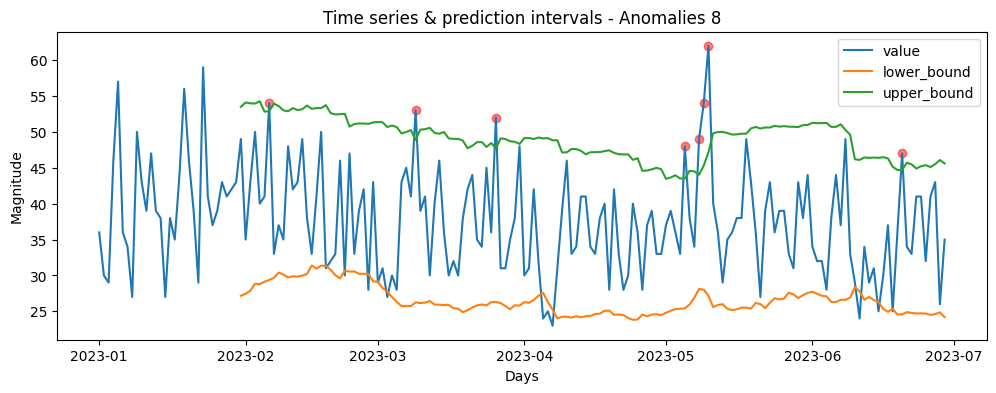

In [5]:
from alerts import plot
from alerts.time_series import AnomalyMeanTS
from alerts.dataclasses import TimeSeries

dates = df_time_series.date.values
values = df_time_series.value.values
ts = TimeSeries(dates, values)
mean_ts = AnomalyMeanTS(ts)

plot.plot(mean_ts, show_anomalies=True)

In [6]:
from alerts.anomaly import AnomalyDetector

detector = AnomalyDetector()
anomaly_events = detector.detect_alerts(mean_ts)
anomaly_events

[Event(), Event(), Event(), Event(), Event(), Event(), Event(), Event()]

In [7]:
for anomaly in anomaly_events:
    print(anomaly.date, anomaly.value)

2023-02-06T00:00:00.000000000 54
2023-03-09T00:00:00.000000000 53
2023-03-26T00:00:00.000000000 52
2023-05-05T00:00:00.000000000 48
2023-05-08T00:00:00.000000000 49
2023-05-09T00:00:00.000000000 54
2023-05-10T00:00:00.000000000 62
2023-06-20T00:00:00.000000000 47


In [8]:
from alerts.anomaly import AnomalyDetector

detector = AnomalyDetector()
groups = detector.detect_alerts_groups(mean_ts)
groups

[[Event()],
 [Event()],
 [Event()],
 [Event(), Event(), Event(), Event()],
 [Event()]]

In [9]:
for i, group in enumerate(groups, start=1):
    print(f"Group: {i}")
    print(10 * "***")
    for event in group:
        print(event.date, event.value)

Group: 1
******************************
2023-02-06T00:00:00.000000000 54
Group: 2
******************************
2023-03-09T00:00:00.000000000 53
Group: 3
******************************
2023-03-26T00:00:00.000000000 52
Group: 4
******************************
2023-05-05T00:00:00.000000000 48
2023-05-08T00:00:00.000000000 49
2023-05-09T00:00:00.000000000 54
2023-05-10T00:00:00.000000000 62
Group: 5
******************************
2023-06-20T00:00:00.000000000 47


In [10]:
ts.events[:4]

[Event(), Event(), Event(), Event()]

In [11]:
mean_ts.prediction_interval()[:4]

[PredictionInterval(),
 PredictionInterval(),
 PredictionInterval(),
 PredictionInterval()]

In [12]:
prediction_interval = mean_ts.prediction_interval()
dates = [e.date for e in prediction_interval]
values = [e.value for e in prediction_interval]
lower_bounds = [e.lower_bound for e in prediction_interval]
upper_bounds = [e.upper_bound for e in prediction_interval]

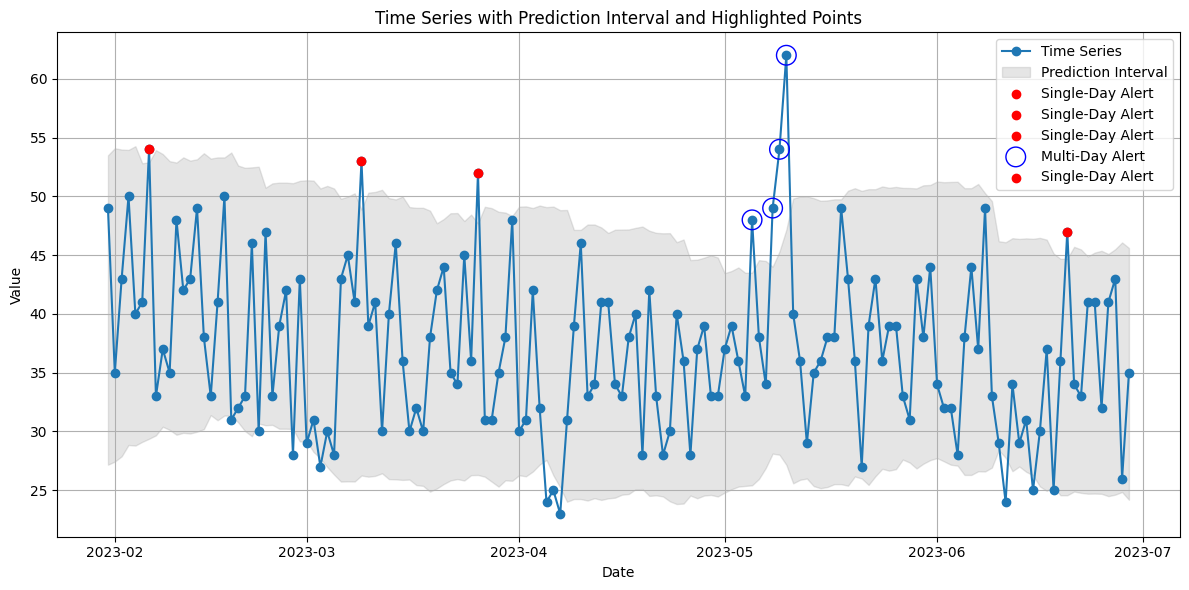

In [13]:
import matplotlib.pyplot as plt

window = 30

dates = [e.date for e in ts.events]

plt.figure(figsize=(12, 6))

plt.plot(
    dates[window:], values[window:], marker="o", linestyle="-", label="Time Series"
)

plt.fill_between(
    dates[window:],
    lower_bounds[window:],
    upper_bounds[window:],
    color="gray",
    alpha=0.2,
    label="Prediction Interval",
)

for group in groups:
    group_dates = [point.date for point in group]
    group_volumes = [point.value for point in group]

    if len(group_dates) == 1:
        # Single-day alert
        plt.scatter(
            group_dates,
            group_volumes,
            color="red",
            zorder=5,
            label="Single-Day Alert",
            marker="o",
        )
    else:
        # Multiple-day alert
        plt.scatter(
            group_dates,
            group_volumes,
            color="blue",
            zorder=5,
            label="Multi-Day Alert",
            marker="o",
            facecolors="none",
            s=200,
        )

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series with Prediction Interval and Highlighted Points")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()